In [14]:
# 清空内核状态
%reset -f

In [15]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
setup_seed(123456)

In [16]:
#要设置的参数
Ex=0#E也要放小e6倍，这里是0就不放了
Ey=0
Ez=0#托卡马克里面没电场
B0=5#磁轴中心的磁感应强度为5T
q=2.5#安全因子，注意，不是电荷
R0=6.2#托卡马克大半径6.2m
q_over_m = 4.822452834e1  # 电荷与质量之比

#单位问题：跑太大的数，程序吃不消，得归一化。几个大数，q_over_m = 4.8e7，vx0vy0 1e6 5e6，interval 4.1473e-9，要动
#程序中，要让轨迹相对形状不变，又因为B和位置有关，所以轨迹数值也不能变
#a=q/m（E+vB），x=vt+0.5at^2
#让位移x=vt+0.5at^2不变，让interval扩大e6倍，让v缩小e6倍(让v0和x0在同一量级，这样好训练)，让q_over_m缩小e6倍，E也要放小e6倍，这样a放小e12个
def Bx(x,y,z):
    return B0/q*(-q*R0*y+z*x)/(x**2+y**2)
def By(x,y,z):
    return B0/q*(q*R0*x+z*y)/(x**2+y**2)
def Bz(x,y,z):
    return B0/q*(-1+R0/(x**2+y**2)**0.5)
    

target_x0=torch.tensor([7.2])
target_y0=torch.tensor([0.0])
target_z0=torch.tensor([0.0])
target_vx0=torch.tensor([1.0])
target_vy0=torch.tensor([5.0])#这里是通行α粒子数据
target_vz0=torch.tensor([0.0])


interval=4.147267104135095e-4#根据学长给的数据取值,e-3是小圈的1/2π,e-4就是小圈的60分之一，更精确
#总运动时间是n*interval
learning_rate=8e-4

stop_condition = 5e-4#停止训练的loss值要求


#设置初始权重
lamda1=2#lpde权重
lamda2=400#lE权重
lamda3=600#l0权重




In [17]:
n=100#训练中的t共n个时间点,注意画三维图的点不建议超过200个，容易炸内核
n_all=500#总覆盖时间点数，绘图用
jump=0#单位是interval
n_epoch=100#每几次epoch就计数

n_test=50#在n_all范围内，等距取多少个test点
new_prefix = "8.2.duansui-100"  # 新的文件名前缀

In [18]:
#Neural Network
#t作为输入，x,y,z作为输出，中间三个隐藏层
#MLP是最基础的全连接神经网络

class SinActivation(torch.nn.Module):
    def __init__(self):
        super(SinActivation, self).__init__()
        self.a = nn.Parameter(torch.tensor(0.1))  # 将a设置为可学习的参数

    def forward(self, x):
        return torch.sin(self.a *10* x)

class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1,128),#0层
            SinActivation(),#1层
            torch.nn.Linear(128,128),#2层
            SinActivation(),#3
            torch.nn.Linear(128,128),#4
            SinActivation(),#5
            torch.nn.Linear(128,128),#6
            SinActivation(),#7
            torch.nn.Linear(128,3),#8
        )
         # 对每个线性层进行Glorot初始化
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
    def forward(self,x):
        return self.net(x)
    
    
u = MLP()  # 网络名称



In [19]:
# import torch
# #from ceshi_Copy1 import MLP  # 导入你的模型类定义

# # 创建模型实例
# # u = MyModel()

# # 加载模型参数
# u.load_state_dict(torch.load('3.1.1保存.pth'))

# # 设置模型为评估模式（如果只是进行推理）
# # u.eval()

In [20]:


#下面是求导
def gradients(x,t,order=1):
    if order == 1:
        return torch.autograd.grad(x,t,grad_outputs=torch.ones_like(x),#用于计算某个标量相对于一组输入张量的梯度
                                  create_graph = True,
                                  only_inputs=True,)[0]#create_graph： 这是一个布尔值，如果设置为 True，则创建一个用于计算更高阶梯度的计算图。
                                                    #这对于执行高阶梯度的操作是有用的。在训练深度学习模型时，可能需要计算模型参数的二阶梯度。
    else:
        return gradients(gradients(x,t),t,order = order-1)#二阶及以上导

In [21]:


#损失函数
#LOSS
loss = torch.nn.MSELoss()
tensortarget = (target_vx0**2+target_vy0**2+target_vz0**2)**0.5
target_initial = tensortarget.repeat(n+1).view(-1, 1)#保能量项用的

def funcmiu(x,y,z,vx,vy,vz):
    miu=(vx**2+vy**2+vz**2)/(Bx(x,y,z)**2+By(x,y,z)**2+Bz(x,y,z)**2)**0.5-(vx*Bx(x,y,z)+vy*By(x,y,z)+vz*Bz(x,y,z))**2/(Bx(x,y,z)**2+By(x,y,z)**2+Bz(x,y,z)**2)**1.5
    return miu


def LOSS(u):
    
    samples = torch.arange(jump*interval, (n_all+1+jump)*interval, step=int(n_all/n)*interval)+torch.rand(n+1) * interval*int(n_all/n)*1   #random jitter to samples 10%#实际上n+1个点
    t = samples.view(-1, 1).requires_grad_(True)
    x = u(t)[:, 0].view(-1, 1)
    y = u(t)[:, 1].view(-1, 1)
    z = u(t)[:, 2].view(-1, 1)
    vx = gradients(x, t, 1)
    vy = gradients(y, t, 1)
    vz = gradients(z, t, 1)

    lpde1 = loss(gradients(vx, t, 1), q_over_m*(Ex + vy * Bz(x,y,z) - vz * By(x,y,z)))
    lpde2 = loss(gradients(vy, t, 1), q_over_m*(Ey + vz * Bx(x,y,z) - vx * Bz(x,y,z)))
    lpde3 = loss(gradients(vz, t, 1), q_over_m*(Ez + vx * By(x,y,z) - vy * Bx(x,y,z)))

    lE = loss((vx**2+vy**2+vz**2)**0.5,target_initial)
    miu=funcmiu(x,y,z,vx,vy,vz)
    lpde = lpde1 + lpde2 + lpde3 

    t0=torch.tensor([0.0]).requires_grad_(True)
    l00=(u(t0)[0] - target_x0)**2
    l01=(u(t0)[1] - target_y0)**2
    l02=(u(t0)[2] - target_z0)**2
    l03=(gradients(u(t0)[0],t0,1) - target_vx0)**2
    l04=(gradients(u(t0)[1],t0,1) - target_vy0)**2
    l05=(gradients(u(t0)[2],t0,1) - target_vz0)**2
    l0=l00+l01+l02+l03+l04+l05

    return lpde,lE,l0


In [22]:
opt = torch.optim.Adam(u.parameters(), lr=learning_rate)
def funcweight(lpde):
    lpde.backward(retain_graph=True)#初态只对第0层的weight的梯度才全是0，其他情况都有梯度
    # 获取网络的参数列表
    gradientlw0 = u.net[0].weight.grad.clone()
    gradientlb0 = u.net[0].bias.grad.clone()
    gradientlw2 = u.net[2].weight.grad.clone()
    gradientlb2 = u.net[2].bias.grad.clone()
    gradientlw4 = u.net[4].weight.grad.clone()
    gradientlb4 = u.net[4].bias.grad.clone()
    gradientlw6 = u.net[6].weight.grad.clone()
    gradientlb6 = u.net[6].bias.grad.clone()
    gradientlw8 = u.net[8].weight.grad.clone()
    gradientlb8 = u.net[8].bias.grad.clone()
    opt.zero_grad()
    tensors_l = [gradientlw0,gradientlb0,gradientlw2,gradientlb2,gradientlw4,gradientlb4,gradientlw6,gradientlb6,
                gradientlw8,gradientlb8]
    squared_sums = [torch.sum(tensor ** 2) for tensor in tensors_l]
    # 将所有平方和相加
    total_squared_sum = sum(squared_sums)
    l2_norm_gradient_l=(total_squared_sum.item())**0.5
    return l2_norm_gradient_l

In [23]:
# 加载文本文件
xdata = np.loadtxt('通行x_real.txt')
# 从第四个数据开始，每隔10个数据读取一个，共读取50个数据
xselected_data = xdata[jump::int(n_all/n_test)][:(n_test+1)]
# 将所选数据转换为PyTorch张量
x_real = torch.tensor(xselected_data, dtype=torch.float32).view(-1,1)

ydata = np.loadtxt('通行y_real.txt')
yselected_data = ydata[jump::int(n_all/n_test)][:(n_test+1)]
y_real = torch.tensor(yselected_data, dtype=torch.float32).view(-1,1)

zdata = np.loadtxt('通行z_real.txt')
zselected_data = zdata[jump::int(n_all/n_test)][:(n_test+1)]
z_real = torch.tensor(zselected_data, dtype=torch.float32).view(-1,1)




xdata=None
ydata=None
zdata=None
xselected_data=None
yselected_data=None
zselected_data=None

#x_real：用于训练过程神经网络输出值与真实值对比，3，13,23…493共50个时刻点，对应t_test
#x_real_plt：用于绘制真实图，0~500全点


In [24]:
#训练过程中记录的量
loss_list=[]#总损失，带权重
lpde_list=[]#方程项损失
l0_list=[]#初态损失
lE_list=[]#能量项损失loss，也是与真实能量做对比diff
# lamda1_list=[]#方程项权重，把保能量保磁矩也放在这一项
# lamda2_list=[]#能量项权重
# lamda3_list=[]#初态权重
# l_withoutweight_list=[]#总损失，不带权重
# time_list=[]#训练时间记录
loss_test_list=[]#部分时刻点，输出位置与真实位置误差向量的模平方，即位置与真实值的误差
lossmean_test_list=[]#部分时刻点，输出位置与真实位置误差的算术平均值，(sigma（xn+yn+zn）-sigma(xc+yc+zc))/n ,证明轨迹可以视为导心
# miu_train_list=[]

In [25]:
import os

file_lists = [loss_list, lpde_list, l0_list, lE_list, loss_test_list, lossmean_test_list]
file_names = ['hh_loss.txt', 'hh_lpde.txt', 'hh_l0.txt', 'hh_lE.txt', 'hh_loss_test.txt', 'hh_lossmean_test.txt']

def Save():
    for file_list, old_name in zip(file_lists, file_names):
        # 构建新文件名，保留原始文件名中的后缀部分
        new_name = new_prefix + old_name[2:]

        # 检查是否已经存在该文件，如果存在，则在文件末尾追加写入
        if os.path.exists(new_name):
            mode = 'a'  # 追加模式
        else:
            mode = 'w'  # 新建文件模式

        # 打开文件进行写入
        with open(new_name, mode) as f:
            for item in file_list:
                f.write("%s\n" % item)

        # 清空列表
        file_list.clear()

In [26]:
import time
start_time = time.time()#计时
epochs = 100000  #训练次数
opt = torch.optim.Adam(u.parameters(), lr=learning_rate)

for i in range(epochs):
    opt.zero_grad()
    
    lpde=LOSS(u)[0]
    lE=LOSS(u)[1]
    l0=LOSS(u)[2]
  
    if (i+1)%1000== 0:
        gradient_lpde=funcweight(lpde)
        gradient_lE=funcweight(lE)
        gradient_l0=funcweight(l0) 

    if (i+1)%1000== 0 and lpde>1e-5:
        lamda1=0.2*lamda1+0.8*(  (gradient_lpde+gradient_l0+gradient_lE)/gradient_lpde  )
    if (i+1)%1000== 0 and l0>1e-5:
        lamda3=0.2*lamda3+0.8*(  (gradient_lpde+gradient_l0+gradient_lE)/gradient_l0  )
    if (i+1)%1000== 0 and lE>1e-5:
        lamda2=0.2*lamda2+0.8*(  (gradient_lpde+gradient_l0+gradient_lE)/gradient_lE  )
        
    l_total=lamda1*lpde+lamda3*l0+lamda2*lE
    l_withoutweight=lpde+l0+lE
    l_total.backward()
    opt.step()
    
    
    if (i+1)%1000 == 0:
        learnr = opt.param_groups[0]['lr']
        
        #更新学习率
        learning_rate *=0.952
        for param_group in opt.param_groups:
            param_group['lr'] = learning_rate
    if (i+1)%(n_epoch*40)==0:
        Save()
    
    

    if (i+1)%n_epoch == 0 or i==0:
        end_time = time.time()
        total_time = end_time - start_time
        learnr = opt.param_groups[0]['lr']
        time_test =torch.arange(interval*jump, interval*(n_all+1+jump), interval*int(n_all/n_test))
        t_test = time_test.view(-1, 1).requires_grad_(True)
        x_test = u(t_test)[:, 0].view(-1, 1)
        y_test = u(t_test)[:, 1].view(-1, 1)
        z_test = u(t_test)[:, 2].view(-1, 1)
        vx_test = gradients(x_test,t_test,1)
        vy_test = gradients(y_test,t_test,1)
        vz_test = gradients(z_test,t_test,1)
        loss_test = loss(x_test,x_real)+loss(y_test,y_real)+loss(z_test,z_real)
        miu_train=funcmiu(x_test,y_test,z_test,vx_test,vy_test,vz_test)
        #lcq=lE+lmiu_test#注意这里！！
        lossmean_test = torch.sum(x_test-x_real+y_test-y_real+z_test-z_real)/n
        print(f'Epoch [{i+1}/{epochs}], Loss: {l_total.item():.4g},   LOSS_function: {lpde.item():.4g},   LOSS_E:{lE.item():.4g},    LOSS_initial: {l0.item():.4g},')
        print(f'lamda1:{lamda1:.4g},    lamda2:{lamda2:.4g},    lamda3:{lamda3:.4g},      learn rate:{learnr:.4g},    time: {total_time}' )
        print(f'loss_compared with real:{loss_test:.5g},   miu_train:{miu_train.mean():.4g},    lossmean:{lossmean_test.item():.4g}') 
        loss_list.append(l_total.item())
        lpde_list.append(lpde.item())
        l0_list.append(l0.item())
        lE_list.append(lE.item())
#         lamda1_list.append(lamda1)
#         lamda2_list.append(lamda2)
#         lamda3_list.append(lamda3)
#         l_withoutweight_list.append(l_withoutweight.item())
#         time_list.append(total_time)
        loss_test_list.append(loss_test.item())
        lossmean_test_list.append(lossmean_test.item())
#         miu_train_list.append(miu_train.mean())
    
    if (i+1)%4000 == 0:
        for name, param in u.named_parameters():
            if 'a' in name:  # 筛选出包含'a'的参数
                print(name, param)
        
        
    if l_total <= stop_condition:#刚才写成loss_test了，感觉不妥，毕竟应该不知道真实数字是多少
        print(f'Training stopped at No.{i+1} time. Loss ({l_total}) is below the specified threshold ({stop_condition}).')
        break


Epoch [1/100000], Loss: 1.718e+05,   LOSS_function: 6.057e+04,   LOSS_E:24.66,    LOSS_initial: 68.01,
lamda1:2,    lamda2:400,    lamda3:600,      learn rate:0.0008,    time: 0.08753633499145508
loss_compared with real:27.502,   miu_train:0.0002402,    lossmean:-2.875
Epoch [100/100000], Loss: 2301,   LOSS_function: 663.6,   LOSS_E:0.1261,    LOSS_initial: 1.539,
lamda1:2,    lamda2:400,    lamda3:600,      learn rate:0.0008,    time: 7.155179738998413
loss_compared with real:0.83611,   miu_train:0.004188,    lossmean:-0.05178
Epoch [200/100000], Loss: 512.3,   LOSS_function: 16.96,   LOSS_E:0.0177,    LOSS_initial: 0.7855,
lamda1:2,    lamda2:400,    lamda3:600,      learn rate:0.0008,    time: 14.708080768585205
loss_compared with real:0.2684,   miu_train:0.0002293,    lossmean:-0.07861
Epoch [300/100000], Loss: 420.9,   LOSS_function: 3.532,   LOSS_E:0.0004229,    LOSS_initial: 0.6895,
lamda1:2,    lamda2:400,    lamda3:600,      learn rate:0.0008,    time: 21.499929428100586
loss_

Epoch [3000/100000], Loss: 445.3,   LOSS_function: 15.9,   LOSS_E:4.263e-06,    LOSS_initial: 0.6614,
lamda1:1.01,    lamda2:1.42e+05,    lamda3:648.1,      learn rate:0.0006902,    time: 201.89311861991882
loss_compared with real:0.21208,   miu_train:0.0001983,    lossmean:-0.1453
Epoch [3100/100000], Loss: 445.1,   LOSS_function: 16.07,   LOSS_E:4.229e-06,    LOSS_initial: 0.6608,
lamda1:1.01,    lamda2:1.42e+05,    lamda3:648.1,      learn rate:0.0006902,    time: 209.03709030151367
loss_compared with real:0.21189,   miu_train:0.0002001,    lossmean:-0.1453
Epoch [3200/100000], Loss: 451.7,   LOSS_function: 15.48,   LOSS_E:4.938e-05,    LOSS_initial: 0.6621,
lamda1:1.01,    lamda2:1.42e+05,    lamda3:648.1,      learn rate:0.0006902,    time: 215.70878791809082
loss_compared with real:0.21039,   miu_train:0.0002101,    lossmean:-0.1445
Epoch [3300/100000], Loss: 444.8,   LOSS_function: 16.71,   LOSS_E:4.416e-06,    LOSS_initial: 0.6593,
lamda1:1.01,    lamda2:1.42e+05,    lamda3:648

Epoch [4100/100000], Loss: 426.1,   LOSS_function: 15.04,   LOSS_E:7.525e-06,    LOSS_initial: 0.6593,
lamda1:1.003,    lamda2:4.492e+04,    lamda3:622.9,      learn rate:0.0006571,    time: 276.44407081604004
loss_compared with real:0.21167,   miu_train:0.0001926,    lossmean:-0.1451
Epoch [4200/100000], Loss: 425.9,   LOSS_function: 15.21,   LOSS_E:7.663e-06,    LOSS_initial: 0.6587,
lamda1:1.003,    lamda2:4.492e+04,    lamda3:622.9,      learn rate:0.0006571,    time: 283.8081421852112
loss_compared with real:0.21154,   miu_train:0.0001923,    lossmean:-0.1451
Epoch [4300/100000], Loss: 425.7,   LOSS_function: 15.08,   LOSS_E:7.813e-06,    LOSS_initial: 0.6586,
lamda1:1.003,    lamda2:4.492e+04,    lamda3:622.9,      learn rate:0.0006571,    time: 291.46935200691223
loss_compared with real:0.2114,   miu_train:0.0001925,    lossmean:-0.1451
Epoch [4400/100000], Loss: 425.4,   LOSS_function: 15.16,   LOSS_E:7.877e-06,    LOSS_initial: 0.658,
lamda1:1.003,    lamda2:4.492e+04,    lamd

Epoch [7000/100000], Loss: 1108,   LOSS_function: 71.04,   LOSS_E:4.636e-06,    LOSS_initial: 0.6054,
lamda1:1.001,    lamda2:1.159e+06,    lamda3:1704,      learn rate:0.000567,    time: 496.25243067741394
loss_compared with real:0.19395,   miu_train:0.0005574,    lossmean:-0.1315
Epoch [7100/100000], Loss: 1106,   LOSS_function: 78.09,   LOSS_E:5.141e-06,    LOSS_initial: 0.5994,
lamda1:1.001,    lamda2:1.159e+06,    lamda3:1704,      learn rate:0.000567,    time: 503.50903129577637
loss_compared with real:0.19195,   miu_train:0.0005957,    lossmean:-0.1315
Epoch [7200/100000], Loss: 1104,   LOSS_function: 83.13,   LOSS_E:5.393e-06,    LOSS_initial: 0.5955,
lamda1:1.001,    lamda2:1.159e+06,    lamda3:1704,      learn rate:0.000567,    time: 510.68825793266296
loss_compared with real:0.19067,   miu_train:0.0006222,    lossmean:-0.1315
Epoch [7300/100000], Loss: 1104,   LOSS_function: 86.16,   LOSS_E:5.489e-06,    LOSS_initial: 0.5933,
lamda1:1.001,    lamda2:1.159e+06,    lamda3:1704

Epoch [8100/100000], Loss: 1178,   LOSS_function: 97.43,   LOSS_E:5.396e-06,    LOSS_initial: 0.5856,
lamda1:1.001,    lamda2:4.664e+05,    lamda3:1841,      learn rate:0.0005397,    time: 576.6170423030853
loss_compared with real:0.18807,   miu_train:0.0007029,    lossmean:-0.1287
Epoch [8200/100000], Loss: 1177,   LOSS_function: 105.4,   LOSS_E:5.966e-06,    LOSS_initial: 0.5807,
lamda1:1.001,    lamda2:4.664e+05,    lamda3:1841,      learn rate:0.0005397,    time: 584.1883661746979
loss_compared with real:0.18625,   miu_train:0.0007449,    lossmean:-0.1289
Epoch [8300/100000], Loss: 1177,   LOSS_function: 108.8,   LOSS_E:6.23e-06,    LOSS_initial: 0.5787,
lamda1:1.001,    lamda2:4.664e+05,    lamda3:1841,      learn rate:0.0005397,    time: 592.033772945404
loss_compared with real:0.18555,   miu_train:0.0007622,    lossmean:-0.1289
Epoch [8400/100000], Loss: 1176,   LOSS_function: 109.7,   LOSS_E:6.33e-06,    LOSS_initial: 0.5778,
lamda1:1.001,    lamda2:4.664e+05,    lamda3:1841,  

Epoch [11100/100000], Loss: 1191,   LOSS_function: 116.8,   LOSS_E:5.129e-06,    LOSS_initial: 0.5665,
lamda1:1.001,    lamda2:4.664e+05,    lamda3:1892,      learn rate:0.0004657,    time: 805.5487048625946
loss_compared with real:0.18137,   miu_train:0.00082,    lossmean:-0.1273
Epoch [11200/100000], Loss: 1265,   LOSS_function: 114.6,   LOSS_E:0.000169,    LOSS_initial: 0.5663,
lamda1:1.001,    lamda2:4.664e+05,    lamda3:1892,      learn rate:0.0004657,    time: 812.8279595375061
loss_compared with real:0.18327,   miu_train:0.000836,    lossmean:-0.13
Epoch [11300/100000], Loss: 1190,   LOSS_function: 117,   LOSS_E:4.66e-06,    LOSS_initial: 0.5658,
lamda1:1.001,    lamda2:4.664e+05,    lamda3:1892,      learn rate:0.0004657,    time: 820.0396301746368
loss_compared with real:0.18143,   miu_train:0.0008167,    lossmean:-0.1272
Epoch [11400/100000], Loss: 1190,   LOSS_function: 118.9,   LOSS_E:4.737e-06,    LOSS_initial: 0.5647,
lamda1:1.001,    lamda2:4.664e+05,    lamda3:1892,    

Epoch [12100/100000], Loss: 1200,   LOSS_function: 122.2,   LOSS_E:4.816e-06,    LOSS_initial: 0.5589,
lamda1:1.001,    lamda2:4.664e+05,    lamda3:1924,      learn rate:0.0004433,    time: 877.907744884491
loss_compared with real:0.17896,   miu_train:0.0008472,    lossmean:-0.1263
Epoch [12200/100000], Loss: 1199,   LOSS_function: 122.2,   LOSS_E:4.952e-06,    LOSS_initial: 0.5581,
lamda1:1.001,    lamda2:4.664e+05,    lamda3:1924,      learn rate:0.0004433,    time: 885.0803172588348
loss_compared with real:0.17905,   miu_train:0.0008563,    lossmean:-0.1261
Epoch [12300/100000], Loss: 1197,   LOSS_function: 122.5,   LOSS_E:3.886e-06,    LOSS_initial: 0.5575,
lamda1:1.001,    lamda2:4.664e+05,    lamda3:1924,      learn rate:0.0004433,    time: 892.8534963130951
loss_compared with real:0.17851,   miu_train:0.0008476,    lossmean:-0.126
Epoch [12400/100000], Loss: 1197,   LOSS_function: 121.6,   LOSS_E:3.436e-06,    LOSS_initial: 0.5578,
lamda1:1.001,    lamda2:4.664e+05,    lamda3:19

Epoch [15000/100000], Loss: 1126,   LOSS_function: 212.9,   LOSS_E:4.677e-06,    LOSS_initial: 0.4541,
lamda1:1,    lamda2:4.664e+05,    lamda3:2005,      learn rate:0.0003825,    time: 1099.2677462100983
loss_compared with real:0.1476,   miu_train:0.001394,    lossmean:-0.1078
Epoch [15100/100000], Loss: 1125,   LOSS_function: 223.9,   LOSS_E:6.579e-06,    LOSS_initial: 0.448,
lamda1:1,    lamda2:4.664e+05,    lamda3:2005,      learn rate:0.0003825,    time: 1106.4789080619812
loss_compared with real:0.14508,   miu_train:0.001455,    lossmean:-0.1058
Epoch [15200/100000], Loss: 1129,   LOSS_function: 222.8,   LOSS_E:1.228e-05,    LOSS_initial: 0.4491,
lamda1:1,    lamda2:4.664e+05,    lamda3:2005,      learn rate:0.0003825,    time: 1113.6421689987183
loss_compared with real:0.14442,   miu_train:0.001445,    lossmean:-0.1061
Epoch [15300/100000], Loss: 1142,   LOSS_function: 227.2,   LOSS_E:4.295e-05,    LOSS_initial: 0.4461,
lamda1:1,    lamda2:4.664e+05,    lamda3:2005,      learn r

Epoch [16100/100000], Loss: 1037,   LOSS_function: 205.6,   LOSS_E:5.663e-06,    LOSS_initial: 0.4519,
lamda1:1.001,    lamda2:3.343e+05,    lamda3:1836,      learn rate:0.0003642,    time: 1178.9237763881683
loss_compared with real:0.14571,   miu_train:0.001416,    lossmean:-0.1075
Epoch [16200/100000], Loss: 1035,   LOSS_function: 200.5,   LOSS_E:5.612e-06,    LOSS_initial: 0.4533,
lamda1:1.001,    lamda2:3.343e+05,    lamda3:1836,      learn rate:0.0003642,    time: 1186.090383052826
loss_compared with real:0.14563,   miu_train:0.001413,    lossmean:-0.1077
Epoch [16300/100000], Loss: 1034,   LOSS_function: 211.7,   LOSS_E:5.459e-06,    LOSS_initial: 0.4467,
lamda1:1.001,    lamda2:3.343e+05,    lamda3:1836,      learn rate:0.0003642,    time: 1193.7828018665314
loss_compared with real:0.1461,   miu_train:0.00135,    lossmean:-0.1069
Epoch [16400/100000], Loss: 1036,   LOSS_function: 194.3,   LOSS_E:6.061e-06,    LOSS_initial: 0.4573,
lamda1:1.001,    lamda2:3.343e+05,    lamda3:183

Epoch [19000/100000], Loss: 520,   LOSS_function: 95.11,   LOSS_E:6.808e-06,    LOSS_initial: 0.4802,
lamda1:1.001,    lamda2:1.113e+05,    lamda3:882.9,      learn rate:0.0003142,    time: 1400.8045063018799
loss_compared with real:0.14924,   miu_train:0.000656,    lossmean:-0.1125
Epoch [19100/100000], Loss: 515,   LOSS_function: 80.62,   LOSS_E:4.721e-06,    LOSS_initial: 0.4913,
lamda1:1.001,    lamda2:1.113e+05,    lamda3:882.9,      learn rate:0.0003142,    time: 1407.9951283931732
loss_compared with real:0.15964,   miu_train:0.0006417,    lossmean:-0.1167
Epoch [19200/100000], Loss: 566.9,   LOSS_function: 107.4,   LOSS_E:1.027e-05,    LOSS_initial: 0.519,
lamda1:1.001,    lamda2:1.113e+05,    lamda3:882.9,      learn rate:0.0003142,    time: 1415.2194645404816
loss_compared with real:0.14975,   miu_train:0.001437,    lossmean:-0.1125
Epoch [19300/100000], Loss: 511.7,   LOSS_function: 79.65,   LOSS_E:8.311e-06,    LOSS_initial: 0.4881,
lamda1:1.001,    lamda2:1.113e+05,    lamd

Epoch [20100/100000], Loss: 449,   LOSS_function: 70.7,   LOSS_E:2.905e-06,    LOSS_initial: 0.4995,
lamda1:1.001,    lamda2:1.113e+05,    lamda3:756.6,      learn rate:0.0002991,    time: 1480.4815063476562
loss_compared with real:0.15824,   miu_train:0.0006272,    lossmean:-0.1157
Epoch [20200/100000], Loss: 464.7,   LOSS_function: 85.4,   LOSS_E:7.298e-05,    LOSS_initial: 0.4905,
lamda1:1.001,    lamda2:1.113e+05,    lamda3:756.6,      learn rate:0.0002991,    time: 1487.6951417922974
loss_compared with real:0.16159,   miu_train:0.0005326,    lossmean:-0.1196
Epoch [20300/100000], Loss: 447.5,   LOSS_function: 68.51,   LOSS_E:3.754e-06,    LOSS_initial: 0.5002,
lamda1:1.001,    lamda2:1.113e+05,    lamda3:756.6,      learn rate:0.0002991,    time: 1495.335459947586
loss_compared with real:0.16131,   miu_train:0.0006643,    lossmean:-0.1176
Epoch [20400/100000], Loss: 469,   LOSS_function: 109.3,   LOSS_E:7.592e-06,    LOSS_initial: 0.4742,
lamda1:1.001,    lamda2:1.113e+05,    lamd

Epoch [23000/100000], Loss: 581.5,   LOSS_function: 81.8,   LOSS_E:3.853e-06,    LOSS_initial: 0.4861,
lamda1:1.001,    lamda2:1.577e+05,    lamda3:1027,      learn rate:0.0002581,    time: 1701.7261519432068
loss_compared with real:0.17199,   miu_train:0.0008001,    lossmean:-0.1232
Epoch [23100/100000], Loss: 574,   LOSS_function: 108,   LOSS_E:5.229e-06,    LOSS_initial: 0.453,
lamda1:1.001,    lamda2:1.577e+05,    lamda3:1027,      learn rate:0.0002581,    time: 1708.8871893882751
loss_compared with real:0.14632,   miu_train:0.0008834,    lossmean:-0.1092
Epoch [23200/100000], Loss: 573.3,   LOSS_function: 109.9,   LOSS_E:1.315e-05,    LOSS_initial: 0.4492,
lamda1:1.001,    lamda2:1.577e+05,    lamda3:1027,      learn rate:0.0002581,    time: 1716.1172904968262
loss_compared with real:0.14247,   miu_train:0.0008338,    lossmean:-0.1068
Epoch [23300/100000], Loss: 583.6,   LOSS_function: 107.4,   LOSS_E:2.781e-05,    LOSS_initial: 0.4594,
lamda1:1.001,    lamda2:1.577e+05,    lamda3

Epoch [24100/100000], Loss: 595.1,   LOSS_function: 109.1,   LOSS_E:3.676e-06,    LOSS_initial: 0.4473,
lamda1:1.001,    lamda2:1.577e+05,    lamda3:1085,      learn rate:0.0002457,    time: 1781.902173280716
loss_compared with real:0.13345,   miu_train:0.001132,    lossmean:-0.103
Epoch [24200/100000], Loss: 596.9,   LOSS_function: 107.7,   LOSS_E:6.221e-05,    LOSS_initial: 0.4417,
lamda1:1.001,    lamda2:1.577e+05,    lamda3:1085,      learn rate:0.0002457,    time: 1789.029140472412
loss_compared with real:0.13637,   miu_train:0.001145,    lossmean:-0.1045
Epoch [24300/100000], Loss: 600.8,   LOSS_function: 129.2,   LOSS_E:7.672e-05,    LOSS_initial: 0.4235,
lamda1:1.001,    lamda2:1.577e+05,    lamda3:1085,      learn rate:0.0002457,    time: 1796.6403794288635
loss_compared with real:0.13221,   miu_train:0.001078,    lossmean:-0.1017
Epoch [24400/100000], Loss: 594.6,   LOSS_function: 133.4,   LOSS_E:4.051e-05,    LOSS_initial: 0.4191,
lamda1:1.001,    lamda2:1.577e+05,    lamda3

Epoch [27000/100000], Loss: 623.8,   LOSS_function: 184.5,   LOSS_E:4.75e-06,    LOSS_initial: 0.3281,
lamda1:1.001,    lamda2:1.577e+05,    lamda3:1336,      learn rate:0.000212,    time: 2005.746387720108
loss_compared with real:0.12368,   miu_train:0.001966,    lossmean:-0.09544
Epoch [27100/100000], Loss: 706.4,   LOSS_function: 81.02,   LOSS_E:9.16e-06,    LOSS_initial: 0.4669,
lamda1:1.001,    lamda2:1.577e+05,    lamda3:1336,      learn rate:0.000212,    time: 2013.0985219478607
loss_compared with real:0.10667,   miu_train:0.001167,    lossmean:-0.07927
Epoch [27200/100000], Loss: 624.4,   LOSS_function: 210.6,   LOSS_E:6.823e-06,    LOSS_initial: 0.3088,
lamda1:1.001,    lamda2:1.577e+05,    lamda3:1336,      learn rate:0.000212,    time: 2020.211360692978
loss_compared with real:0.10037,   miu_train:0.001409,    lossmean:-0.08099
Epoch [27300/100000], Loss: 1027,   LOSS_function: 204.5,   LOSS_E:0.002609,    LOSS_initial: 0.3073,
lamda1:1.001,    lamda2:1.577e+05,    lamda3:13

Epoch [28100/100000], Loss: 427.8,   LOSS_function: 119.6,   LOSS_E:7.304e-06,    LOSS_initial: 0.3711,
lamda1:1.001,    lamda2:1.534e+05,    lamda3:827.1,      learn rate:0.0002018,    time: 2085.569615125656
loss_compared with real:0.12451,   miu_train:0.0009778,    lossmean:-0.0953
Epoch [28200/100000], Loss: 494.3,   LOSS_function: 112.9,   LOSS_E:0.0004419,    LOSS_initial: 0.379,
lamda1:1.001,    lamda2:1.534e+05,    lamda3:827.1,      learn rate:0.0002018,    time: 2092.7781705856323
loss_compared with real:0.12709,   miu_train:0.001034,    lossmean:-0.09694
Epoch [28300/100000], Loss: 448,   LOSS_function: 125.8,   LOSS_E:0.0001237,    LOSS_initial: 0.3664,
lamda1:1.001,    lamda2:1.534e+05,    lamda3:827.1,      learn rate:0.0002018,    time: 2100.452127933502
loss_compared with real:0.12107,   miu_train:0.0008667,    lossmean:-0.09503
Epoch [28400/100000], Loss: 421.2,   LOSS_function: 101.5,   LOSS_E:6.468e-06,    LOSS_initial: 0.3852,
lamda1:1.001,    lamda2:1.534e+05,    l

Epoch [31000/100000], Loss: 573.8,   LOSS_function: 198.1,   LOSS_E:5.14e-06,    LOSS_initial: 0.2622,
lamda1:1.001,    lamda2:1.534e+05,    lamda3:1429,      learn rate:0.0001741,    time: 2306.8379049301147
loss_compared with real:0.1238,   miu_train:0.002563,    lossmean:-0.09406
Epoch [31100/100000], Loss: 750,   LOSS_function: 211.4,   LOSS_E:2.449e-05,    LOSS_initial: 0.3741,
lamda1:1.001,    lamda2:1.534e+05,    lamda3:1429,      learn rate:0.0001741,    time: 2314.0602877140045
loss_compared with real:0.12369,   miu_train:0.001481,    lossmean:-0.09501
Epoch [31200/100000], Loss: 754.4,   LOSS_function: 225.5,   LOSS_E:0.0002149,    LOSS_initial: 0.3469,
lamda1:1.001,    lamda2:1.534e+05,    lamda3:1429,      learn rate:0.0001741,    time: 2321.120217561722
loss_compared with real:0.11349,   miu_train:0.001528,    lossmean:-0.09111
Epoch [31300/100000], Loss: 706.3,   LOSS_function: 214.5,   LOSS_E:2.375e-05,    LOSS_initial: 0.3414,
lamda1:1.001,    lamda2:1.534e+05,    lamda

Epoch [32100/100000], Loss: 598.5,   LOSS_function: 143.4,   LOSS_E:1.111e-05,    LOSS_initial: 0.3855,
lamda1:1.001,    lamda2:2.141e+05,    lamda3:1174,      learn rate:0.0001658,    time: 2386.093681335449
loss_compared with real:0.12437,   miu_train:0.001168,    lossmean:-0.09815
Epoch [32200/100000], Loss: 591.2,   LOSS_function: 145.3,   LOSS_E:1.013e-05,    LOSS_initial: 0.3778,
lamda1:1.001,    lamda2:2.141e+05,    lamda3:1174,      learn rate:0.0001658,    time: 2393.5379042625427
loss_compared with real:0.12272,   miu_train:0.001213,    lossmean:-0.09695
Epoch [32300/100000], Loss: 589.7,   LOSS_function: 153.4,   LOSS_E:1.01e-05,    LOSS_initial: 0.3697,
lamda1:1.001,    lamda2:2.141e+05,    lamda3:1174,      learn rate:0.0001658,    time: 2401.3483426570892
loss_compared with real:0.12242,   miu_train:0.00124,    lossmean:-0.09671
Epoch [32400/100000], Loss: 590.2,   LOSS_function: 161.3,   LOSS_E:1.007e-05,    LOSS_initial: 0.3633,
lamda1:1.001,    lamda2:2.141e+05,    lam

Epoch [35000/100000], Loss: 528.7,   LOSS_function: 131.6,   LOSS_E:2.294e-05,    LOSS_initial: 0.353,
lamda1:1.001,    lamda2:3.644e+05,    lamda3:1101,      learn rate:0.000143,    time: 2608.6561136245728
loss_compared with real:0.1184,   miu_train:0.001386,    lossmean:-0.09403
Epoch [35100/100000], Loss: 568.1,   LOSS_function: 132.9,   LOSS_E:8.046e-06,    LOSS_initial: 0.3926,
lamda1:1.001,    lamda2:3.644e+05,    lamda3:1101,      learn rate:0.000143,    time: 2615.906801700592
loss_compared with real:0.13505,   miu_train:0.001133,    lossmean:-0.09829
Epoch [35200/100000], Loss: 557.3,   LOSS_function: 130,   LOSS_E:7.243e-06,    LOSS_initial: 0.3857,
lamda1:1.001,    lamda2:3.644e+05,    lamda3:1101,      learn rate:0.000143,    time: 2622.998293876648
loss_compared with real:0.12632,   miu_train:0.001132,    lossmean:-0.1004
Epoch [35300/100000], Loss: 559,   LOSS_function: 135.5,   LOSS_E:7.779e-06,    LOSS_initial: 0.382,
lamda1:1.001,    lamda2:3.644e+05,    lamda3:1101, 

Epoch [36100/100000], Loss: 579.9,   LOSS_function: 160.3,   LOSS_E:6.963e-06,    LOSS_initial: 0.345,
lamda1:1.001,    lamda2:3.644e+05,    lamda3:1209,      learn rate:0.0001362,    time: 2688.352266073227
loss_compared with real:0.10996,   miu_train:0.001344,    lossmean:-0.08929
Epoch [36200/100000], Loss: 580.7,   LOSS_function: 173.5,   LOSS_E:6.431e-06,    LOSS_initial: 0.3348,
lamda1:1.001,    lamda2:3.644e+05,    lamda3:1209,      learn rate:0.0001362,    time: 2695.6379475593567
loss_compared with real:0.10916,   miu_train:0.001426,    lossmean:-0.08905
Epoch [36300/100000], Loss: 572.6,   LOSS_function: 162.4,   LOSS_E:5.898e-06,    LOSS_initial: 0.3374,
lamda1:1.001,    lamda2:3.644e+05,    lamda3:1209,      learn rate:0.0001362,    time: 2703.184605360031
loss_compared with real:0.1089,   miu_train:0.001389,    lossmean:-0.08827
Epoch [36400/100000], Loss: 562,   LOSS_function: 164.5,   LOSS_E:5.665e-06,    LOSS_initial: 0.3271,
lamda1:1.001,    lamda2:3.644e+05,    lamda3

Epoch [39000/100000], Loss: 833.4,   LOSS_function: 154.4,   LOSS_E:3.441e-06,    LOSS_initial: 0.3646,
lamda1:1.001,    lamda2:1.667e+05,    lamda3:1861,      learn rate:0.0001175,    time: 2909.7893192768097
loss_compared with real:0.14014,   miu_train:0.002164,    lossmean:-0.1028
Epoch [39100/100000], Loss: 753.9,   LOSS_function: 295.1,   LOSS_E:8.221e-06,    LOSS_initial: 0.2457,
lamda1:1.001,    lamda2:1.667e+05,    lamda3:1861,      learn rate:0.0001175,    time: 2917.033362388611
loss_compared with real:0.082179,   miu_train:0.002346,    lossmean:-0.07375
Epoch [39200/100000], Loss: 734.7,   LOSS_function: 273.6,   LOSS_E:8.938e-06,    LOSS_initial: 0.2469,
lamda1:1.001,    lamda2:1.667e+05,    lamda3:1861,      learn rate:0.0001175,    time: 2924.228512763977
loss_compared with real:0.078387,   miu_train:0.002474,    lossmean:-0.07054
Epoch [39300/100000], Loss: 716.4,   LOSS_function: 259.7,   LOSS_E:1.003e-05,    LOSS_initial: 0.2444,
lamda1:1.001,    lamda2:1.667e+05,    l

Epoch [40100/100000], Loss: 1798,   LOSS_function: 301.3,   LOSS_E:1.74e-06,    LOSS_initial: 0.6967,
lamda1:1,    lamda2:2.801e+06,    lamda3:2141,      learn rate:0.0001118,    time: 2990.5981764793396
loss_compared with real:0.02599,   miu_train:0.002094,    lossmean:0.05789
Epoch [40200/100000], Loss: 1409,   LOSS_function: 233.9,   LOSS_E:1.961e-06,    LOSS_initial: 0.5465,
lamda1:1,    lamda2:2.801e+06,    lamda3:2141,      learn rate:0.0001118,    time: 2997.871391773224
loss_compared with real:0.07087,   miu_train:0.001639,    lossmean:-0.0285
Epoch [40300/100000], Loss: 1290,   LOSS_function: 217.7,   LOSS_E:2.553e-06,    LOSS_initial: 0.4974,
lamda1:1,    lamda2:2.801e+06,    lamda3:2141,      learn rate:0.0001118,    time: 3005.527473449707
loss_compared with real:0.099524,   miu_train:0.001548,    lossmean:-0.0673
Epoch [40400/100000], Loss: 1230,   LOSS_function: 209,   LOSS_E:2.794e-06,    LOSS_initial: 0.4731,
lamda1:1,    lamda2:2.801e+06,    lamda3:2141,      learn rat

Epoch [43100/100000], Loss: 1047,   LOSS_function: 301.2,   LOSS_E:7.358e-06,    LOSS_initial: 0.3179,
lamda1:1,    lamda2:2.801e+06,    lamda3:2281,      learn rate:9.649e-05,    time: 3220.207806825638
loss_compared with real:0.10204,   miu_train:0.002258,    lossmean:-0.08444
Epoch [43200/100000], Loss: 1036,   LOSS_function: 296.4,   LOSS_E:7.449e-06,    LOSS_initial: 0.3152,
lamda1:1,    lamda2:2.801e+06,    lamda3:2281,      learn rate:9.649e-05,    time: 3227.438595533371
loss_compared with real:0.10102,   miu_train:0.002275,    lossmean:-0.08383
Epoch [43300/100000], Loss: 1036,   LOSS_function: 300.6,   LOSS_E:7.764e-06,    LOSS_initial: 0.3127,
lamda1:1,    lamda2:2.801e+06,    lamda3:2281,      learn rate:9.649e-05,    time: 3234.5649650096893
loss_compared with real:0.10035,   miu_train:0.00229,    lossmean:-0.08339
Epoch [43400/100000], Loss: 1024,   LOSS_function: 297.4,   LOSS_E:7.911e-06,    LOSS_initial: 0.309,
lamda1:1,    lamda2:2.801e+06,    lamda3:2281,      learn 

Epoch [44100/100000], Loss: 1025,   LOSS_function: 332.7,   LOSS_E:1.087e-05,    LOSS_initial: 0.2872,
lamda1:1,    lamda2:7.919e+05,    lamda3:2379,      learn rate:9.186e-05,    time: 3292.502790212631
loss_compared with real:0.090944,   miu_train:0.002499,    lossmean:-0.07849
Epoch [44200/100000], Loss: 1016,   LOSS_function: 332.3,   LOSS_E:1.236e-05,    LOSS_initial: 0.2834,
lamda1:1,    lamda2:7.919e+05,    lamda3:2379,      learn rate:9.186e-05,    time: 3299.70791220665
loss_compared with real:0.089922,   miu_train:0.002528,    lossmean:-0.07792
Epoch [44300/100000], Loss: 1017,   LOSS_function: 341.9,   LOSS_E:1.279e-05,    LOSS_initial: 0.2795,
lamda1:1,    lamda2:7.919e+05,    lamda3:2379,      learn rate:9.186e-05,    time: 3307.3504362106323
loss_compared with real:0.089167,   miu_train:0.002563,    lossmean:-0.07745
Epoch [44400/100000], Loss: 997.4,   LOSS_function: 330,   LOSS_E:1.345e-05,    LOSS_initial: 0.2761,
lamda1:1,    lamda2:7.919e+05,    lamda3:2379,      lea

Epoch [47100/100000], Loss: 1167,   LOSS_function: 379.4,   LOSS_E:9.653e-06,    LOSS_initial: 0.2599,
lamda1:1,    lamda2:8.595e+06,    lamda3:2713,      learn rate:7.925e-05,    time: 3521.7612867355347
loss_compared with real:0.088242,   miu_train:0.002895,    lossmean:-0.07614
Epoch [47200/100000], Loss: 1164,   LOSS_function: 374.4,   LOSS_E:9.473e-06,    LOSS_initial: 0.2608,
lamda1:1,    lamda2:8.595e+06,    lamda3:2713,      learn rate:7.925e-05,    time: 3528.959797143936
loss_compared with real:0.087367,   miu_train:0.002866,    lossmean:-0.07534
Epoch [47300/100000], Loss: 1154,   LOSS_function: 367.7,   LOSS_E:9.574e-06,    LOSS_initial: 0.2596,
lamda1:1,    lamda2:8.595e+06,    lamda3:2713,      learn rate:7.925e-05,    time: 3536.1871995925903
loss_compared with real:0.087141,   miu_train:0.002887,    lossmean:-0.07525
Epoch [47400/100000], Loss: 1162,   LOSS_function: 379.3,   LOSS_E:9.417e-06,    LOSS_initial: 0.2586,
lamda1:1,    lamda2:8.595e+06,    lamda3:2713,      

Epoch [48100/100000], Loss: 1181,   LOSS_function: 391.1,   LOSS_E:9.286e-06,    LOSS_initial: 0.2503,
lamda1:1,    lamda2:8.595e+06,    lamda3:2835,      learn rate:7.545e-05,    time: 3594.0625245571136
loss_compared with real:0.083903,   miu_train:0.003006,    lossmean:-0.07342
Epoch [48200/100000], Loss: 1186,   LOSS_function: 396.8,   LOSS_E:9.491e-06,    LOSS_initial: 0.2496,
lamda1:1,    lamda2:8.595e+06,    lamda3:2835,      learn rate:7.545e-05,    time: 3601.2558224201202
loss_compared with real:0.083597,   miu_train:0.003014,    lossmean:-0.07307
Epoch [48300/100000], Loss: 1193,   LOSS_function: 399.6,   LOSS_E:9.853e-06,    LOSS_initial: 0.25,
lamda1:1,    lamda2:8.595e+06,    lamda3:2835,      learn rate:7.545e-05,    time: 3608.831651687622
loss_compared with real:0.082992,   miu_train:0.002991,    lossmean:-0.07272
Epoch [48400/100000], Loss: 1183,   LOSS_function: 394.7,   LOSS_E:9.77e-06,    LOSS_initial: 0.2486,
lamda1:1,    lamda2:8.595e+06,    lamda3:2835,      lea

Epoch [51100/100000], Loss: 1312,   LOSS_function: 516.1,   LOSS_E:3.123e-06,    LOSS_initial: 0.2418,
lamda1:1,    lamda2:2.029e+07,    lamda3:3028,      learn rate:6.51e-05,    time: 3822.8282766342163
loss_compared with real:0.079371,   miu_train:0.003463,    lossmean:-0.07393
Epoch [51200/100000], Loss: 1295,   LOSS_function: 515.7,   LOSS_E:2.838e-06,    LOSS_initial: 0.2381,
lamda1:1,    lamda2:2.029e+07,    lamda3:3028,      learn rate:6.51e-05,    time: 3830.0474741458893
loss_compared with real:0.07532,   miu_train:0.003497,    lossmean:-0.07023
Epoch [51300/100000], Loss: 1289,   LOSS_function: 521.5,   LOSS_E:2.543e-06,    LOSS_initial: 0.2365,
lamda1:1,    lamda2:2.029e+07,    lamda3:3028,      learn rate:6.51e-05,    time: 3837.212343454361
loss_compared with real:0.073268,   miu_train:0.003501,    lossmean:-0.0684
Epoch [51400/100000], Loss: 1274,   LOSS_function: 513.8,   LOSS_E:2.44e-06,    LOSS_initial: 0.2347,
lamda1:1,    lamda2:2.029e+07,    lamda3:3028,      learn 

Epoch [52100/100000], Loss: 1258,   LOSS_function: 517.4,   LOSS_E:1.999e-06,    LOSS_initial: 0.2314,
lamda1:1,    lamda2:2.029e+07,    lamda3:3022,      learn rate:6.197e-05,    time: 3895.73469042778
loss_compared with real:0.071296,   miu_train:0.003522,    lossmean:-0.0665
Epoch [52200/100000], Loss: 1246,   LOSS_function: 502.2,   LOSS_E:2.127e-06,    LOSS_initial: 0.2319,
lamda1:1,    lamda2:2.029e+07,    lamda3:3022,      learn rate:6.197e-05,    time: 3902.9494535923004
loss_compared with real:0.0712,   miu_train:0.003506,    lossmean:-0.06634
Epoch [52300/100000], Loss: 1236,   LOSS_function: 495.1,   LOSS_E:2.092e-06,    LOSS_initial: 0.2311,
lamda1:1,    lamda2:2.029e+07,    lamda3:3022,      learn rate:6.197e-05,    time: 3910.5070440769196
loss_compared with real:0.071392,   miu_train:0.003519,    lossmean:-0.06639
Epoch [52400/100000], Loss: 1236,   LOSS_function: 494.8,   LOSS_E:2.007e-06,    LOSS_initial: 0.2318,
lamda1:1,    lamda2:2.029e+07,    lamda3:3022,      lear

Epoch [55100/100000], Loss: 1143,   LOSS_function: 407,   LOSS_E:3.835e-06,    LOSS_initial: 0.2362,
lamda1:1,    lamda2:2.029e+07,    lamda3:2785,      learn rate:5.347e-05,    time: 4123.510652303696
loss_compared with real:0.07385,   miu_train:0.003075,    lossmean:-0.06845
Epoch [55200/100000], Loss: 1153,   LOSS_function: 405.5,   LOSS_E:4.191e-06,    LOSS_initial: 0.2378,
lamda1:1,    lamda2:2.029e+07,    lamda3:2785,      learn rate:5.347e-05,    time: 4130.636428833008
loss_compared with real:0.074141,   miu_train:0.00302,    lossmean:-0.06881
Epoch [55300/100000], Loss: 1165,   LOSS_function: 407.4,   LOSS_E:4.675e-06,    LOSS_initial: 0.238,
lamda1:1,    lamda2:2.029e+07,    lamda3:2785,      learn rate:5.347e-05,    time: 4137.86848282814
loss_compared with real:0.073681,   miu_train:0.003016,    lossmean:-0.06897
Epoch [55400/100000], Loss: 1844,   LOSS_function: 407.2,   LOSS_E:3.852e-05,    LOSS_initial: 0.2353,
lamda1:1,    lamda2:2.029e+07,    lamda3:2785,      learn ra

Epoch [56100/100000], Loss: 1066,   LOSS_function: 371,   LOSS_E:2.665e-06,    LOSS_initial: 0.242,
lamda1:1,    lamda2:2.029e+07,    lamda3:2649,      learn rate:5.09e-05,    time: 4195.650913238525
loss_compared with real:0.075123,   miu_train:0.002843,    lossmean:-0.06986
Epoch [56200/100000], Loss: 1207,   LOSS_function: 397.6,   LOSS_E:8.508e-06,    LOSS_initial: 0.2405,
lamda1:1,    lamda2:2.029e+07,    lamda3:2649,      learn rate:5.09e-05,    time: 4202.879946947098
loss_compared with real:0.075955,   miu_train:0.00287,    lossmean:-0.06986
Epoch [56300/100000], Loss: 1322,   LOSS_function: 368.1,   LOSS_E:1.541e-05,    LOSS_initial: 0.2419,
lamda1:1,    lamda2:2.029e+07,    lamda3:2649,      learn rate:5.09e-05,    time: 4210.247080087662
loss_compared with real:0.075844,   miu_train:0.002853,    lossmean:-0.06979
Epoch [56400/100000], Loss: 1074,   LOSS_function: 367.6,   LOSS_E:3.375e-06,    LOSS_initial: 0.2409,
lamda1:1,    lamda2:2.029e+07,    lamda3:2649,      learn rat

Epoch [59100/100000], Loss: 875.7,   LOSS_function: 340.8,   LOSS_E:5.831e-06,    LOSS_initial: 0.2064,
lamda1:1,    lamda2:4.319e+06,    lamda3:2469,      learn rate:4.392e-05,    time: 4423.548321485519
loss_compared with real:0.066156,   miu_train:0.002894,    lossmean:-0.0622
Epoch [59200/100000], Loss: 893.4,   LOSS_function: 366.4,   LOSS_E:4.949e-06,    LOSS_initial: 0.2047,
lamda1:1,    lamda2:4.319e+06,    lamda3:2469,      learn rate:4.392e-05,    time: 4430.859430551529
loss_compared with real:0.064849,   miu_train:0.002872,    lossmean:-0.06159
Epoch [59300/100000], Loss: 892,   LOSS_function: 359.7,   LOSS_E:4.67e-06,    LOSS_initial: 0.2073,
lamda1:1,    lamda2:4.319e+06,    lamda3:2469,      learn rate:4.392e-05,    time: 4438.088266134262
loss_compared with real:0.064367,   miu_train:0.002867,    lossmean:-0.06118
Epoch [59400/100000], Loss: 870.2,   LOSS_function: 333.9,   LOSS_E:4.497e-06,    LOSS_initial: 0.2093,
lamda1:1,    lamda2:4.319e+06,    lamda3:2469,      le

Epoch [60100/100000], Loss: 848.3,   LOSS_function: 331,   LOSS_E:1.03e-05,    LOSS_initial: 0.2134,
lamda1:1,    lamda2:4.319e+06,    lamda3:2215,      learn rate:4.181e-05,    time: 4495.65867805481
loss_compared with real:0.06467,   miu_train:0.002597,    lossmean:-0.0609
Epoch [60200/100000], Loss: 840.3,   LOSS_function: 318.9,   LOSS_E:1.207e-05,    LOSS_initial: 0.2118,
lamda1:1,    lamda2:4.319e+06,    lamda3:2215,      learn rate:4.181e-05,    time: 4502.871577978134
loss_compared with real:0.065275,   miu_train:0.002682,    lossmean:-0.06129
Epoch [60300/100000], Loss: 837.5,   LOSS_function: 344.6,   LOSS_E:4.819e-06,    LOSS_initial: 0.213,
lamda1:1,    lamda2:4.319e+06,    lamda3:2215,      learn rate:4.181e-05,    time: 4510.022583246231
loss_compared with real:0.064423,   miu_train:0.002628,    lossmean:-0.06098
Epoch [60400/100000], Loss: 826.9,   LOSS_function: 331.1,   LOSS_E:6.055e-06,    LOSS_initial: 0.2119,
lamda1:1,    lamda2:4.319e+06,    lamda3:2215,      learn

Epoch [63000/100000], Loss: 696.7,   LOSS_function: 267.3,   LOSS_E:8.242e-06,    LOSS_initial: 0.2281,
lamda1:1.001,    lamda2:4.319e+06,    lamda3:1726,      learn rate:3.608e-05,    time: 4716.999276638031
loss_compared with real:0.072108,   miu_train:0.002288,    lossmean:-0.06602
Epoch [63100/100000], Loss: 678.2,   LOSS_function: 263.2,   LOSS_E:4.126e-06,    LOSS_initial: 0.23,
lamda1:1.001,    lamda2:4.319e+06,    lamda3:1726,      learn rate:3.608e-05,    time: 4724.195331096649
loss_compared with real:0.073215,   miu_train:0.002219,    lossmean:-0.06712
Epoch [63200/100000], Loss: 667.6,   LOSS_function: 235.1,   LOSS_E:4.5e-06,    LOSS_initial: 0.2392,
lamda1:1.001,    lamda2:4.319e+06,    lamda3:1726,      learn rate:3.608e-05,    time: 4731.436817407608
loss_compared with real:0.072907,   miu_train:0.002169,    lossmean:-0.06699
Epoch [63300/100000], Loss: 661.2,   LOSS_function: 239.5,   LOSS_E:3.269e-06,    LOSS_initial: 0.2361,
lamda1:1.001,    lamda2:4.319e+06,    lamd

Epoch [64100/100000], Loss: 665.3,   LOSS_function: 221.7,   LOSS_E:9.7e-06,    LOSS_initial: 0.2452,
lamda1:1.001,    lamda2:4.319e+06,    lamda3:1638,      learn rate:3.434e-05,    time: 4796.727648973465
loss_compared with real:0.075035,   miu_train:0.002094,    lossmean:-0.06805
Epoch [64200/100000], Loss: 642.2,   LOSS_function: 236.5,   LOSS_E:3.703e-06,    LOSS_initial: 0.2378,
lamda1:1.001,    lamda2:4.319e+06,    lamda3:1638,      learn rate:3.434e-05,    time: 4803.98848938942
loss_compared with real:0.074942,   miu_train:0.00211,    lossmean:-0.06862
Epoch [64300/100000], Loss: 655.8,   LOSS_function: 232.1,   LOSS_E:6.828e-06,    LOSS_initial: 0.2406,
lamda1:1.001,    lamda2:4.319e+06,    lamda3:1638,      learn rate:3.434e-05,    time: 4811.274129390717
loss_compared with real:0.074808,   miu_train:0.002118,    lossmean:-0.06769
Epoch [64400/100000], Loss: 643,   LOSS_function: 232.9,   LOSS_E:4.109e-06,    LOSS_initial: 0.2394,
lamda1:1.001,    lamda2:4.319e+06,    lamda3

Epoch [67000/100000], Loss: 688.9,   LOSS_function: 282.5,   LOSS_E:5.612e-06,    LOSS_initial: 0.2145,
lamda1:1.001,    lamda2:4.319e+06,    lamda3:1781,      learn rate:2.963e-05,    time: 5018.22900557518
loss_compared with real:0.066284,   miu_train:0.002225,    lossmean:-0.0618
Epoch [67100/100000], Loss: 665,   LOSS_function: 272.2,   LOSS_E:3.805e-06,    LOSS_initial: 0.2112,
lamda1:1.001,    lamda2:4.319e+06,    lamda3:1781,      learn rate:2.963e-05,    time: 5025.4993715286255
loss_compared with real:0.06705,   miu_train:0.002376,    lossmean:-0.06271
Epoch [67200/100000], Loss: 657.6,   LOSS_function: 267.2,   LOSS_E:4.818e-06,    LOSS_initial: 0.2075,
lamda1:1.001,    lamda2:4.319e+06,    lamda3:1781,      learn rate:2.963e-05,    time: 5032.769629955292
loss_compared with real:0.067332,   miu_train:0.002408,    lossmean:-0.06237
Epoch [67300/100000], Loss: 649,   LOSS_function: 253.7,   LOSS_E:4.029e-06,    LOSS_initial: 0.2121,
lamda1:1.001,    lamda2:4.319e+06,    lamda3

Epoch [68100/100000], Loss: 599.8,   LOSS_function: 230.5,   LOSS_E:3.481e-06,    LOSS_initial: 0.2332,
lamda1:1.001,    lamda2:4.319e+06,    lamda3:1518,      learn rate:2.821e-05,    time: 5098.090695619583
loss_compared with real:0.074349,   miu_train:0.002063,    lossmean:-0.06699
Epoch [68200/100000], Loss: 589.4,   LOSS_function: 219.9,   LOSS_E:4.306e-06,    LOSS_initial: 0.2311,
lamda1:1.001,    lamda2:4.319e+06,    lamda3:1518,      learn rate:2.821e-05,    time: 5105.205067157745
loss_compared with real:0.074126,   miu_train:0.002088,    lossmean:-0.06729
Epoch [68300/100000], Loss: 605.9,   LOSS_function: 220.4,   LOSS_E:6.779e-06,    LOSS_initial: 0.2345,
lamda1:1.001,    lamda2:4.319e+06,    lamda3:1518,      learn rate:2.821e-05,    time: 5112.373106956482
loss_compared with real:0.074348,   miu_train:0.002008,    lossmean:-0.06677
Epoch [68400/100000], Loss: 615,   LOSS_function: 247.3,   LOSS_E:5.22e-06,    LOSS_initial: 0.2272,
lamda1:1.001,    lamda2:4.319e+06,    lam

Epoch [71000/100000], Loss: 560.3,   LOSS_function: 223.2,   LOSS_E:3.708e-06,    LOSS_initial: 0.2348,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:1411,      learn rate:2.434e-05,    time: 5319.0629024505615
loss_compared with real:0.076912,   miu_train:0.001985,    lossmean:-0.06819
Epoch [71100/100000], Loss: 524.7,   LOSS_function: 204.2,   LOSS_E:4.17e-06,    LOSS_initial: 0.2225,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:1411,      learn rate:2.434e-05,    time: 5326.332924604416
loss_compared with real:0.075249,   miu_train:0.00218,    lossmean:-0.06664
Epoch [71200/100000], Loss: 549.4,   LOSS_function: 216.5,   LOSS_E:3.745e-06,    LOSS_initial: 0.2317,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:1411,      learn rate:2.434e-05,    time: 5333.48664689064
loss_compared with real:0.074199,   miu_train:0.002095,    lossmean:-0.06607
Epoch [71300/100000], Loss: 531.4,   LOSS_function: 209.3,   LOSS_E:5.043e-06,    LOSS_initial: 0.2227,
lamda1:1.001,    lamda2:1.524e+06,    la

Epoch [72100/100000], Loss: 504.6,   LOSS_function: 198.8,   LOSS_E:3.929e-06,    LOSS_initial: 0.2415,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:1241,      learn rate:2.317e-05,    time: 5398.389005184174
loss_compared with real:0.080042,   miu_train:0.001831,    lossmean:-0.06986
Epoch [72200/100000], Loss: 510.6,   LOSS_function: 211,   LOSS_E:3.513e-06,    LOSS_initial: 0.237,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:1241,      learn rate:2.317e-05,    time: 5405.474062919617
loss_compared with real:0.080087,   miu_train:0.001893,    lossmean:-0.0697
Epoch [72300/100000], Loss: 504.6,   LOSS_function: 197.4,   LOSS_E:4.586e-06,    LOSS_initial: 0.2418,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:1241,      learn rate:2.317e-05,    time: 5412.7598440647125
loss_compared with real:0.079625,   miu_train:0.001811,    lossmean:-0.06924
Epoch [72400/100000], Loss: 491.6,   LOSS_function: 172.8,   LOSS_E:4.565e-06,    LOSS_initial: 0.2512,
lamda1:1.001,    lamda2:1.524e+06,    lam

Epoch [75000/100000], Loss: 484.1,   LOSS_function: 186.5,   LOSS_E:7.834e-06,    LOSS_initial: 0.2365,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:1207,      learn rate:1.999e-05,    time: 5619.844811916351
loss_compared with real:0.079659,   miu_train:0.001882,    lossmean:-0.06969
Epoch [75100/100000], Loss: 496.4,   LOSS_function: 201,   LOSS_E:3.188e-06,    LOSS_initial: 0.2406,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:1207,      learn rate:1.999e-05,    time: 5627.130358695984
loss_compared with real:0.07413,   miu_train:0.001806,    lossmean:-0.06561
Epoch [75200/100000], Loss: 477.2,   LOSS_function: 200.1,   LOSS_E:3.352e-06,    LOSS_initial: 0.2252,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:1207,      learn rate:1.999e-05,    time: 5634.43616437912
loss_compared with real:0.075829,   miu_train:0.001887,    lossmean:-0.06645
Epoch [75300/100000], Loss: 461.8,   LOSS_function: 175.3,   LOSS_E:4.23e-06,    LOSS_initial: 0.2319,
lamda1:1.001,    lamda2:1.524e+06,    lamda

Epoch [76100/100000], Loss: 447.4,   LOSS_function: 170.5,   LOSS_E:7.38e-06,    LOSS_initial: 0.2389,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:1111,      learn rate:1.903e-05,    time: 5700.114885091782
loss_compared with real:0.077543,   miu_train:0.00177,    lossmean:-0.0676
Epoch [76200/100000], Loss: 425.9,   LOSS_function: 146.3,   LOSS_E:3.655e-06,    LOSS_initial: 0.2465,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:1111,      learn rate:1.903e-05,    time: 5707.328968048096
loss_compared with real:0.078115,   miu_train:0.001746,    lossmean:-0.06805
Epoch [76300/100000], Loss: 420.8,   LOSS_function: 144.5,   LOSS_E:3.463e-06,    LOSS_initial: 0.2438,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:1111,      learn rate:1.903e-05,    time: 5714.508059024811
loss_compared with real:0.07789,   miu_train:0.001836,    lossmean:-0.0685
Epoch [76400/100000], Loss: 467,   LOSS_function: 186.8,   LOSS_E:4.178e-06,    LOSS_initial: 0.2464,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:

Epoch [79000/100000], Loss: 367.6,   LOSS_function: 137.8,   LOSS_E:5.405e-06,    LOSS_initial: 0.2374,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:932.4,      learn rate:1.642e-05,    time: 5921.365507602692
loss_compared with real:0.078332,   miu_train:0.001911,    lossmean:-0.06835
Epoch [79100/100000], Loss: 390.6,   LOSS_function: 148.8,   LOSS_E:3.601e-06,    LOSS_initial: 0.2532,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:932.4,      learn rate:1.642e-05,    time: 5928.594958305359
loss_compared with real:0.086238,   miu_train:0.001658,    lossmean:-0.07253
Epoch [79200/100000], Loss: 387.7,   LOSS_function: 136,   LOSS_E:3.916e-06,    LOSS_initial: 0.2633,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:932.4,      learn rate:1.642e-05,    time: 5935.866690158844
loss_compared with real:0.084368,   miu_train:0.00158,    lossmean:-0.07135
Epoch [79300/100000], Loss: 385.5,   LOSS_function: 147.2,   LOSS_E:3.891e-06,    LOSS_initial: 0.249,
lamda1:1.001,    lamda2:1.524e+06,    l

Epoch [80100/100000], Loss: 378.7,   LOSS_function: 148.1,   LOSS_E:3.91e-06,    LOSS_initial: 0.2593,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:865.8,      learn rate:1.563e-05,    time: 6000.936195611954
loss_compared with real:0.088721,   miu_train:0.001592,    lossmean:-0.07439
Epoch [80200/100000], Loss: 374.6,   LOSS_function: 129.4,   LOSS_E:3.754e-06,    LOSS_initial: 0.2765,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:865.8,      learn rate:1.563e-05,    time: 6008.184942245483
loss_compared with real:0.088447,   miu_train:0.00155,    lossmean:-0.07354
Epoch [80300/100000], Loss: 374.6,   LOSS_function: 126.7,   LOSS_E:3.647e-06,    LOSS_initial: 0.2797,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:865.8,      learn rate:1.563e-05,    time: 6015.466613769531
loss_compared with real:0.088602,   miu_train:0.001466,    lossmean:-0.0741
Epoch [80400/100000], Loss: 386,   LOSS_function: 141.2,   LOSS_E:5.475e-06,    LOSS_initial: 0.2729,
lamda1:1.001,    lamda2:1.524e+06,    la

Epoch [83000/100000], Loss: 364,   LOSS_function: 142.3,   LOSS_E:4.788e-06,    LOSS_initial: 0.2397,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:893.8,      learn rate:1.349e-05,    time: 6222.240947723389
loss_compared with real:0.079283,   miu_train:0.00178,    lossmean:-0.0679
Epoch [83100/100000], Loss: 394.1,   LOSS_function: 157.5,   LOSS_E:3.37e-06,    LOSS_initial: 0.2588,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:893.8,      learn rate:1.349e-05,    time: 6229.472244501114
loss_compared with real:0.084363,   miu_train:0.001645,    lossmean:-0.07125
Epoch [83200/100000], Loss: 386.4,   LOSS_function: 147.9,   LOSS_E:3.658e-06,    LOSS_initial: 0.2604,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:893.8,      learn rate:1.349e-05,    time: 6236.601950883865
loss_compared with real:0.085932,   miu_train:0.001588,    lossmean:-0.07235
Epoch [83300/100000], Loss: 388.6,   LOSS_function: 137.6,   LOSS_E:3.998e-06,    LOSS_initial: 0.2738,
lamda1:1.001,    lamda2:1.524e+06,    la

Epoch [84100/100000], Loss: 403.8,   LOSS_function: 161.2,   LOSS_E:3.058e-06,    LOSS_initial: 0.2352,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:1011,      learn rate:1.284e-05,    time: 6301.882886171341
loss_compared with real:0.077452,   miu_train:0.001818,    lossmean:-0.06738
Epoch [84200/100000], Loss: 404.4,   LOSS_function: 162.6,   LOSS_E:3.63e-06,    LOSS_initial: 0.2335,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:1011,      learn rate:1.284e-05,    time: 6309.043587684631
loss_compared with real:0.0787,   miu_train:0.001842,    lossmean:-0.06785
Epoch [84300/100000], Loss: 409.4,   LOSS_function: 162.1,   LOSS_E:4.459e-06,    LOSS_initial: 0.2377,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:1011,      learn rate:1.284e-05,    time: 6316.208721399307
loss_compared with real:0.078199,   miu_train:0.001807,    lossmean:-0.06799
Epoch [84400/100000], Loss: 423.9,   LOSS_function: 191.1,   LOSS_E:3.693e-06,    LOSS_initial: 0.2246,
lamda1:1.001,    lamda2:1.524e+06,    lam

Epoch [87000/100000], Loss: 354.3,   LOSS_function: 136.8,   LOSS_E:4.049e-06,    LOSS_initial: 0.2523,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:836.9,      learn rate:1.108e-05,    time: 6523.48251914978
loss_compared with real:0.081618,   miu_train:0.001669,    lossmean:-0.06973
Epoch [87100/100000], Loss: 370,   LOSS_function: 135.2,   LOSS_E:3.786e-06,    LOSS_initial: 0.2734,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:836.9,      learn rate:1.108e-05,    time: 6530.630918502808
loss_compared with real:0.08772,   miu_train:0.00149,    lossmean:-0.0732
Epoch [87200/100000], Loss: 365.9,   LOSS_function: 132.9,   LOSS_E:3.769e-06,    LOSS_initial: 0.2713,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:836.9,      learn rate:1.108e-05,    time: 6537.864635229111
loss_compared with real:0.089795,   miu_train:0.001531,    lossmean:-0.07465
Epoch [87300/100000], Loss: 380.9,   LOSS_function: 151.6,   LOSS_E:3.672e-06,    LOSS_initial: 0.2671,
lamda1:1.001,    lamda2:1.524e+06,    lam

Epoch [88100/100000], Loss: 351.5,   LOSS_function: 127.7,   LOSS_E:2.806e-06,    LOSS_initial: 0.2705,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:810.9,      learn rate:1.055e-05,    time: 6603.29444694519
loss_compared with real:0.088906,   miu_train:0.001516,    lossmean:-0.07397
Epoch [88200/100000], Loss: 354,   LOSS_function: 123.8,   LOSS_E:3.36e-06,    LOSS_initial: 0.2774,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:810.9,      learn rate:1.055e-05,    time: 6610.5856392383575
loss_compared with real:0.089729,   miu_train:0.001427,    lossmean:-0.0746
Epoch [88300/100000], Loss: 367.7,   LOSS_function: 137.9,   LOSS_E:3.893e-06,    LOSS_initial: 0.2759,
lamda1:1.001,    lamda2:1.524e+06,    lamda3:810.9,      learn rate:1.055e-05,    time: 6617.851647138596
loss_compared with real:0.089856,   miu_train:0.001456,    lossmean:-0.07479
Epoch [88400/100000], Loss: 356.1,   LOSS_function: 135,   LOSS_E:3.78e-06,    LOSS_initial: 0.2653,
lamda1:1.001,    lamda2:1.524e+06,    lamd

Epoch [91000/100000], Loss: 287.6,   LOSS_function: 96.89,   LOSS_E:2.537e-06,    LOSS_initial: 0.3106,
lamda1:1.002,    lamda2:1.524e+06,    lamda3:600.9,      learn rate:9.1e-06,    time: 6825.360821723938
loss_compared with real:0.096263,   miu_train:0.001211,    lossmean:-0.07903
Epoch [91100/100000], Loss: 293.9,   LOSS_function: 91.25,   LOSS_E:2.549e-06,    LOSS_initial: 0.3305,
lamda1:1.002,    lamda2:1.524e+06,    lamda3:600.9,      learn rate:9.1e-06,    time: 6832.535342216492
loss_compared with real:0.10801,   miu_train:0.001061,    lossmean:-0.08525
Epoch [91200/100000], Loss: 307.1,   LOSS_function: 106.1,   LOSS_E:2.351e-06,    LOSS_initial: 0.3283,
lamda1:1.002,    lamda2:1.524e+06,    lamda3:600.9,      learn rate:9.1e-06,    time: 6839.7431762218475
loss_compared with real:0.10841,   miu_train:0.001061,    lossmean:-0.08565
Epoch [91300/100000], Loss: 295.8,   LOSS_function: 92.38,   LOSS_E:2.455e-06,    LOSS_initial: 0.332,
lamda1:1.002,    lamda2:1.524e+06,    lamda

Epoch [92100/100000], Loss: 282.8,   LOSS_function: 91.24,   LOSS_E:2.135e-06,    LOSS_initial: 0.3488,
lamda1:1.002,    lamda2:1.524e+06,    lamda3:539.4,      learn rate:8.663e-06,    time: 6904.82258272171
loss_compared with real:0.11483,   miu_train:0.0009684,    lossmean:-0.08886
Epoch [92200/100000], Loss: 274.6,   LOSS_function: 86.37,   LOSS_E:1.999e-06,    LOSS_initial: 0.343,
lamda1:1.002,    lamda2:1.524e+06,    lamda3:539.4,      learn rate:8.663e-06,    time: 6912.172363996506
loss_compared with real:0.11529,   miu_train:0.0009956,    lossmean:-0.08975
Epoch [92300/100000], Loss: 267.9,   LOSS_function: 78.71,   LOSS_E:2.765e-06,    LOSS_initial: 0.3426,
lamda1:1.002,    lamda2:1.524e+06,    lamda3:539.4,      learn rate:8.663e-06,    time: 6919.366873502731
loss_compared with real:0.11473,   miu_train:0.0009965,    lossmean:-0.08973
Epoch [92400/100000], Loss: 281.8,   LOSS_function: 89.61,   LOSS_E:1.948e-06,    LOSS_initial: 0.3505,
lamda1:1.002,    lamda2:1.524e+06,   

Epoch [95000/100000], Loss: 230.7,   LOSS_function: 63.92,   LOSS_E:1.957e-06,    LOSS_initial: 0.3638,
lamda1:1.002,    lamda2:1.524e+06,    lamda3:449.9,      learn rate:7.475e-06,    time: 7126.555033922195
loss_compared with real:0.12103,   miu_train:0.0009006,    lossmean:-0.09325
Epoch [95100/100000], Loss: 234.7,   LOSS_function: 65.63,   LOSS_E:1.573e-06,    LOSS_initial: 0.3702,
lamda1:1.002,    lamda2:1.524e+06,    lamda3:449.9,      learn rate:7.475e-06,    time: 7133.683512687683
loss_compared with real:0.12693,   miu_train:0.0008484,    lossmean:-0.09664
Epoch [95200/100000], Loss: 229.2,   LOSS_function: 50.44,   LOSS_E:1.824e-06,    LOSS_initial: 0.391,
lamda1:1.002,    lamda2:1.524e+06,    lamda3:449.9,      learn rate:7.475e-06,    time: 7141.0602560043335
loss_compared with real:0.12533,   miu_train:0.0007679,    lossmean:-0.09572
Epoch [95300/100000], Loss: 246.6,   LOSS_function: 69.11,   LOSS_E:1.619e-06,    LOSS_initial: 0.3886,
lamda1:1.002,    lamda2:1.524e+06, 

Epoch [96100/100000], Loss: 215,   LOSS_function: 49.71,   LOSS_E:1.649e-06,    LOSS_initial: 0.406,
lamda1:1.003,    lamda2:1.524e+06,    lamda3:400.6,      learn rate:7.116e-06,    time: 7206.425799608231
loss_compared with real:0.13299,   miu_train:0.0006883,    lossmean:-0.09968
Epoch [96200/100000], Loss: 217.4,   LOSS_function: 58.87,   LOSS_E:1.373e-06,    LOSS_initial: 0.3901,
lamda1:1.003,    lamda2:1.524e+06,    lamda3:400.6,      learn rate:7.116e-06,    time: 7213.615270614624
loss_compared with real:0.13574,   miu_train:0.0007437,    lossmean:-0.1016
Epoch [96300/100000], Loss: 214.4,   LOSS_function: 46.36,   LOSS_E:1.395e-06,    LOSS_initial: 0.4138,
lamda1:1.003,    lamda2:1.524e+06,    lamda3:400.6,      learn rate:7.116e-06,    time: 7220.8709235191345
loss_compared with real:0.13308,   miu_train:0.0006563,    lossmean:-0.1002
Epoch [96400/100000], Loss: 217.1,   LOSS_function: 52.43,   LOSS_E:1.471e-06,    LOSS_initial: 0.4051,
lamda1:1.003,    lamda2:1.524e+06,    l

Epoch [99000/100000], Loss: 216.3,   LOSS_function: 53.07,   LOSS_E:1.347e-06,    LOSS_initial: 0.4038,
lamda1:1.003,    lamda2:1.524e+06,    lamda3:398.8,      learn rate:6.14e-06,    time: 7428.439827203751
loss_compared with real:0.13676,   miu_train:0.0007009,    lossmean:-0.1028
Epoch [99100/100000], Loss: 216.3,   LOSS_function: 51.22,   LOSS_E:1.186e-06,    LOSS_initial: 0.409,
lamda1:1.003,    lamda2:1.524e+06,    lamda3:398.8,      learn rate:6.14e-06,    time: 7435.714047193527
loss_compared with real:0.13528,   miu_train:0.0006659,    lossmean:-0.1022
Epoch [99200/100000], Loss: 225,   LOSS_function: 60.5,   LOSS_E:1.254e-06,    LOSS_initial: 0.4072,
lamda1:1.003,    lamda2:1.524e+06,    lamda3:398.8,      learn rate:6.14e-06,    time: 7443.041531801224
loss_compared with real:0.13399,   miu_train:0.0006733,    lossmean:-0.101
Epoch [99300/100000], Loss: 215.9,   LOSS_function: 53.35,   LOSS_E:1.551e-06,    LOSS_initial: 0.4013,
lamda1:1.003,    lamda2:1.524e+06,    lamda3:3

In [27]:
old_uname='hh.pth'
#保存神经网络
torch.save(u.state_dict(), new_prefix + old_uname[2:])

In [31]:
#计算神经网络的轨迹
output_history= []#想要缩短周期，就调大Bz
for i in range(jump,(n_all+1+jump)):
        # 将当前状态输入神经网络得到下一时刻的状态
        next_state = u.forward(torch.tensor([interval*i]) )#+torch.rand(1) * interval )

        # 记录输出值
        output_history.append(next_state)

import numpy as np
x_coordinates = np.array([x[0].item() for x in output_history])
y_coordinates = np.array([x[1].item() for x in output_history])
z_coordinates = np.array([x[2].item() for x in output_history])

In [32]:
xdata = np.loadtxt('通行x_real.txt')

# 将所选数据转换为PyTorch张量


ydata = np.loadtxt('通行y_real.txt')


zdata = np.loadtxt('通行z_real.txt')





#全500点，用于后续绘图
x_plt=xdata[jump:(n_all+1+jump):1]
y_plt=ydata[jump:(n_all+1+jump):1]
z_plt=zdata[jump:(n_all+1+jump):1]
x_real_plt=torch.tensor(x_plt, dtype=torch.float32).view(-1,1)#真实值的0~500点，
y_real_plt=torch.tensor(y_plt, dtype=torch.float32).view(-1,1)
z_real_plt=torch.tensor(z_plt, dtype=torch.float32).view(-1,1)
vxdata = (np.loadtxt('通行vx_real.txt'))*1e-6
vydata = (np.loadtxt('通行vy_real.txt'))*1e-6
vzdata = (np.loadtxt('通行vz_real.txt'))*1e-6
vx_real_plt=torch.tensor(vxdata[jump:(n_all+1+jump):1], dtype=torch.float32).view(-1,1)
vy_real_plt=torch.tensor(vydata[jump:(n_all+1+jump):1], dtype=torch.float32).view(-1,1)
vz_real_plt=torch.tensor(vzdata[jump:(n_all+1+jump):1], dtype=torch.float32).view(-1,1)

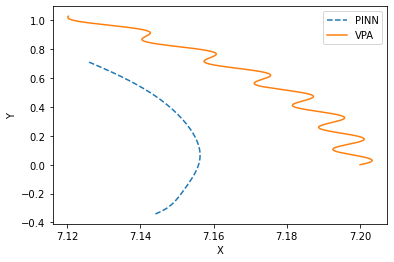

In [33]:
#绘制轨迹，2维
plt.plot(x_coordinates,y_coordinates,linestyle='--', label='PINN')
plt.plot(x_real_plt, y_real_plt,label='VPA')


plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
# plt.title('PINN results VS classic results')
plt.show()

In [13]:
file_lists = [x_coordinates, y_coordinates, z_coordinates]
file_names = ['hh_outputx.txt', 'hh_outputy.txt', 'hh_outputz.txt']

for file_list, old_name in zip(file_lists, file_names):
    new_name = new_prefix + old_name[2:]  # 保留原始文件名中的后缀部分
    with open(new_name, 'w') as f:
        for item in file_list:
            f.write("%s\n" % item)


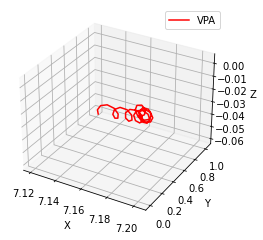

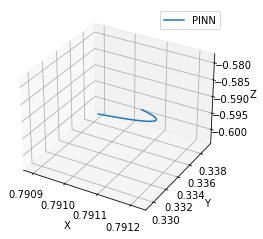

In [14]:
# 绘制轨迹 3维
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_plt[::int(n_all/50)], y_plt[::int(n_all/50)] ,z_plt[::int(n_all/50)],color='red',label='VPA')
#ax.plot(x_coordinates[::int(n_all/100)],y_coordinates[::int(n_all/100)],z_coordinates[::int(n_all/100)],label='neural network')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_title('Particle Motion in Electromagnetic Field')
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.plot(x_plt[::int(n_all/100)], y_plt[::int(n_all/100)] ,z_plt[::int(n_all/100)],label='classic computation')
ax.plot(x_coordinates[::int(n_all/50)],y_coordinates[::int(n_all/50)],z_coordinates[::int(n_all/50)],label='PINN')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_title('Particle Motion in Electromagnetic Field')
plt.show()

In [28]:
with open(new_prefix +'_loss.txt', 'r') as file2:
    loss_list = [float(line.strip()) for line in file2.readlines()]
with open(new_prefix +'_lpde.txt', 'r') as file3:
    lpde_list = [float(line.strip()) for line in file3.readlines()]
with open(new_prefix +'_l0.txt', 'r') as file4:
    l0_list = [float(line.strip()) for line in file4.readlines()]
with open(new_prefix +'_lE.txt', 'r') as file5:
    lE_list = [float(line.strip()) for line in file5.readlines()]
with open(new_prefix +'_loss_test.txt', 'r') as file6:
    loss_test_list = [float(line.strip()) for line in file6.readlines()]
with open(new_prefix +'_lossmean_test.txt', 'r') as file6:
    lossmean_test_list = [float(line.strip()) for line in file6.readlines()]

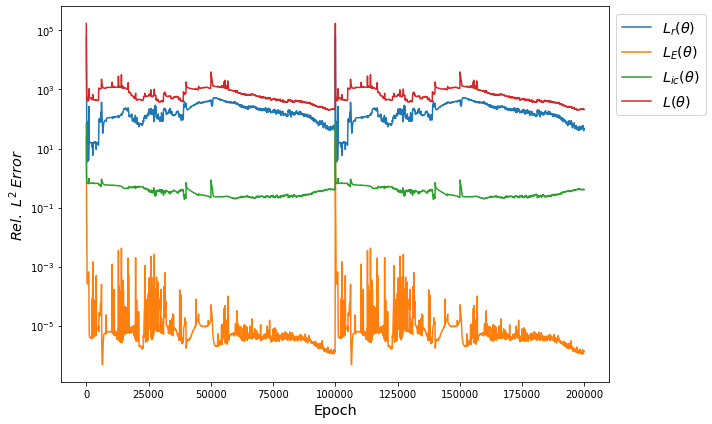

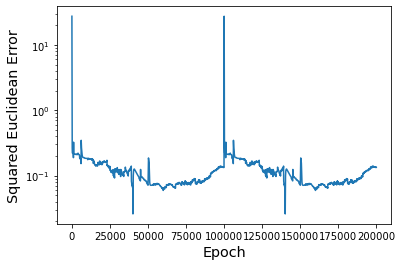

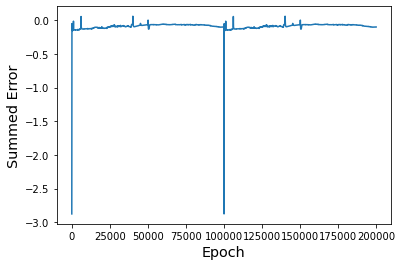

In [29]:
#绘制各loss成分随训练次数epoch变化图
epoch_total = len(loss_list)
epoch_array = np.array(range(0, epoch_total * n_epoch, n_epoch))

plt.figure(figsize=(10, 6))  # 设置图像大小为原始大小的1.3倍，10英寸6英寸
plt.plot(epoch_array,lpde_list,label=r'$L_{r}(\theta)$')
#plt.plot(epoch_array,lmiu_list, label='Loss of μ ')
plt.plot(epoch_array,lE_list, label=r'$L_{E}(\theta)$')
plt.plot(epoch_array,l0_list, label=r'$L_{ic}(\theta)$')
plt.plot(epoch_array,loss_list, label=r'$L(\theta)$')
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel(r'$Rel.\;L^2\;Error$', fontsize='x-large')
# plt.title(r'$Convergence\;of\;rel.\;L^2\;error\;during\;training\;process$')
# 添加图例并设置字体大小，并将其放在图形外部
plt.legend(fontsize='x-large', loc='upper left', bbox_to_anchor=(1, 1))


plt.tight_layout()# 自动调整布局，确保图像完整显示
plt.show()


# plt.plot(epoch_array,lamda1_list,label=r'$λ_{r}(\theta)$')
# plt.plot(epoch_array,lamda2_list,label=r'$λ_{E}(\theta)$')
# plt.plot(epoch_array,lamda3_list,label=r'$λ_{ic}(\theta)$')
# #plt.plot(epoch_array,lamda4_list,label='λ for loss of μ')
# plt.yscale('log')  # 设置纵轴为对数刻度
# plt.xlabel('Epoch', fontsize='x-large')
# plt.ylabel('Adaptive weights', fontsize='x-large')
# # plt.title('Adaptive weights during training process')
# plt.legend(fontsize='x-large', loc='upper left', bbox_to_anchor=(1, 1))

# plt.show()#绘图

plt.plot(epoch_array,loss_test_list)
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel('Squared Euclidean Error', fontsize='x-large')
# plt.title('Geometric difference of position from classic data during training process')

plt.show()#绘图

plt.plot(epoch_array,lossmean_test_list)
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel('Summed Error', fontsize='x-large')
# plt.title('Arithmetic difference of position from classic data during training process')

plt.show()#绘图

In [17]:
#绘制损失函数在各时刻的分布
lpde_tl_list=[]

lE_tl_list=[]

loss_test_tl_list=[]

lossmean_test_tl_list=[]
for i in range(jump,(n_all+1+jump),10):
    t_tl = torch.tensor([i*interval]).view(-1, 1).requires_grad_(True)#tl:trainloss
    x_tl = u(t_tl)[:,0]
    y_tl = u(t_tl)[:,1]
    z_tl = u(t_tl)[:,2]
    vx_tl = gradients(x_tl, t_tl, 1)
    vy_tl = gradients(y_tl, t_tl, 1)
    vz_tl = gradients(z_tl, t_tl, 1)
    lpde1_tl = loss(gradients(vx_tl, t_tl, 1), q_over_m*(Ex + vy_tl * Bz(x_tl,y_tl,z_tl) - vz_tl * By(x_tl,y_tl,z_tl)))
    lpde2_tl = loss(gradients(vy_tl, t_tl, 1), q_over_m*(Ey + vz_tl * Bx(x_tl,y_tl,z_tl) - vx_tl * Bz(x_tl,y_tl,z_tl)))
    lpde3_tl = loss(gradients(vz_tl, t_tl, 1), q_over_m*(Ez + vx_tl * By(x_tl,y_tl,z_tl) - vy_tl * Bx(x_tl,y_tl,z_tl)))
    lE_tl = loss((vx_tl**2+vy_tl**2+vz_tl**2)**0.5,tensortarget)
    lpde_tl = lpde1_tl + lpde2_tl + lpde3_tl
    x_real_tl = x_real_plt[i-jump]
    y_real_tl = y_real_plt[i-jump]
    z_real_tl = z_real_plt[i-jump]
    vx_real_tl = vx_real_plt[i-jump]
    vy_real_tl = vy_real_plt[i-jump]
    vz_real_tl = vz_real_plt[i-jump]
    loss_test_tl = loss(x_tl,x_real_tl)+loss(y_tl,y_real_tl)+loss(z_tl,z_real_tl)
    lossmean_test_tl = (x_tl-x_real_tl+y_tl-y_real_tl+z_tl-z_real_tl)
    lpde_tl_list.append(lpde_tl.item())
    lE_tl_list.append(lE_tl.item())
    loss_test_tl_list.append(loss_test_tl.item())
    lossmean_test_tl_list.append(lossmean_test_tl.item())
tl_array = np.arange(jump*interval, (n_all+1+jump)*interval, 10*interval)




C:\Users\hxm\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [18]:
# 用作提醒
# lpde_tl_list=[]
# lcq_tl_list=[]
# lE_tl_list=[]
# lmiu_tl_list=[]
# loss_test_tl_list=[]
# lmiu_test_tl_list=[]
# lossmean_test_tl_list=[]

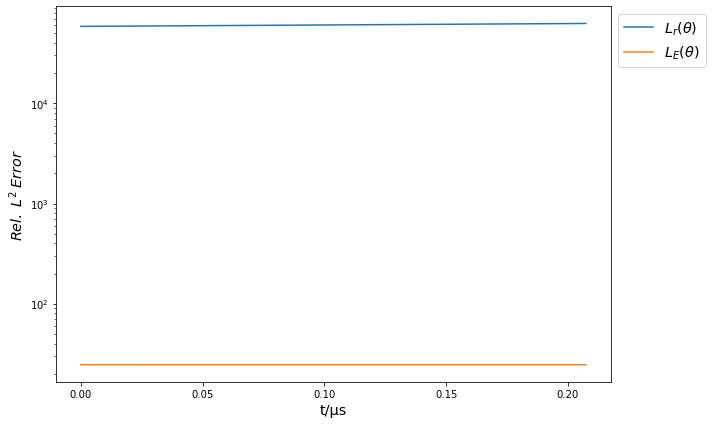

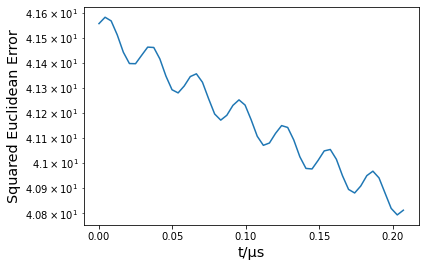

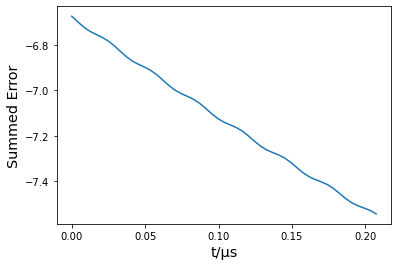

In [19]:
plt.figure(figsize=(10, 6))  # 设置图像大小为原始大小的1.3倍，10英寸6英寸
plt.plot(tl_array,lpde_tl_list,label=r'$L_{r}(\theta)$')
plt.plot(tl_array,lE_tl_list,label=r'$L_{E}(\theta)$')
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('t/μs', fontsize='x-large')
plt.ylabel(r'$Rel.\;L^2\;Error$', fontsize='x-large')
# plt.title('Loss of ODEs and loss of E from real data during motion process')
plt.legend(fontsize='x-large', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()# 自动调整布局，确保图像完整显示
plt.show()
plt.plot(tl_array,loss_test_tl_list)
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('t/μs', fontsize='x-large')
plt.ylabel('Squared Euclidean Error', fontsize='x-large')
# plt.title('Geometric differences of position from real data during motion process')

plt.show()#绘图
plt.plot(tl_array,lossmean_test_tl_list)
plt.xlabel('t/μs', fontsize='x-large')
plt.ylabel('Summed Error', fontsize='x-large')
# plt.title('Arithmetic differences of position from real data during motion process')

plt.show()#绘图

In [20]:
file_lists = [lpde_tl_list,  lE_tl_list,  loss_test_tl_list, lossmean_test_tl_list]
file_names = ['hh_lpde_tl_list.txt', 'hh_lE_tl_list.txt',  'hh_loss_test_tl_list.txt', 'hh_lossmean_test_tl_list.txt']

for file_list, old_name in zip(file_lists, file_names):
    new_name = new_prefix + old_name[2:]  # 保留原始文件名中的后缀部分
    with open(new_name, 'w') as f:
        for item in file_list:
            f.write("%s\n" % item)
